Modified from https://lectures.quantecon.org/jl/markov_asset.html

In [1]:
using Parameters, NamedTuples, MacroTools
#Generator for tuples with keyw
macro with_kw(args...)
    splits = map(args) do arg
        @match arg begin
            (a_ = b_) => (a, b)
            any_ => error("All arguments must be assignments")
        end
    end
    esc(:(
        (;$(map(splits) do pair
            Expr(:kw, pair[1], pair[2])
        end...),) -> 
        $NamedTuples.@NT($(map(splits) do pair
            Expr(:kw, pair[1], pair[1])
        end...))
    ))
end

@with_kw (macro with 1 method)

## Markov growth, risk neutral pricing
First, create a markov chain

In [2]:
using QuantEcon
n = 5
#This generates a finite-space markov chain approximation for:
#  y_t = 0.96 y_{t-1} + 0.25 \epsilon_t
#  where \epsilon_t \sim N (0, 1)

mc = tauchen(n, 0.96, 0.25) #uses n nodes
@show mc.state_values
mc.p

mc.state_values = [-2.67857, -1.33929, 0.0, 1.33929, 2.67857]


5×5 Array{Float64,2}:
 0.987776     0.0122245    1.39888e-14  0.0          0.0        
 0.00190877   0.991227     0.00686433   2.66454e-15  0.0        
 4.65177e-16  0.00369685   0.992606     0.00369685   4.44089e-16
 5.82887e-40  2.61136e-15  0.00686433   0.991227     0.00190877 
 2.7914e-75   9.75194e-39  1.40111e-14  0.0122245    0.987776   

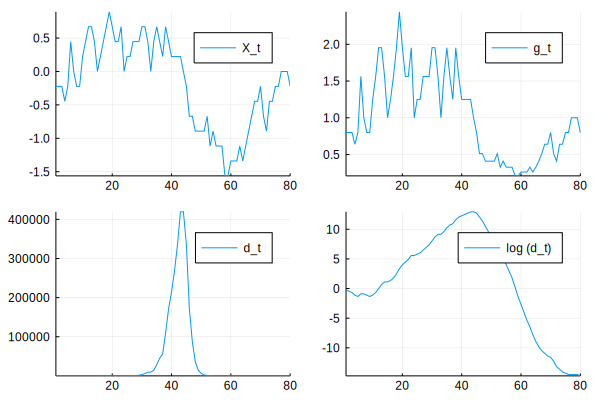

In [3]:
using Plots
n = 25
#This generates a finite-space markov chain approximation for:
#  y_t = 0.96 y_{t-1} + \epsilon_t
#  where \epsilon_t \sim N (0, 0.25^2)

mc = tauchen(n, 0.96, 0.25) #uses n nodes

sim_length = 80
x_0_index = round(Int64, n / 2) #Start at the middle state.  Round to nearest integer

#Simulate underlying state
x_series = simulate(mc, sim_length; init=x_0_index)

#g_t = exp(X_t) from the example
g_series = exp.(x_series)

#From d_{t+1} = g_t d_t.  cumprod does the cumulative product
d_0 = 1.0
d_series = d_0 * cumprod(g_series) #i.e. cumprod([1 2 3 4]) -> [1 2 6 24]

#Plotting the series for all, including the log of the dividends.
series = [x_series g_series d_series log.(d_series)]
labels = ["X_t" "g_t" "d_t" "log (d_t)"]
plot(series, layout=4, labels=labels)

## Pricing
Let $v_t$ be the price dividend ratio for the ex-dividend
$$
v(X_t) = \beta E_t\left[g(X_{t+1})(1 + v(X_{t+1})\right]
$$
For a discrete-state problem, this can be reduced to the system
$$v = \beta K(1+v)$$
with $K(x,y) = g(y)P(x,y)$ from (9)

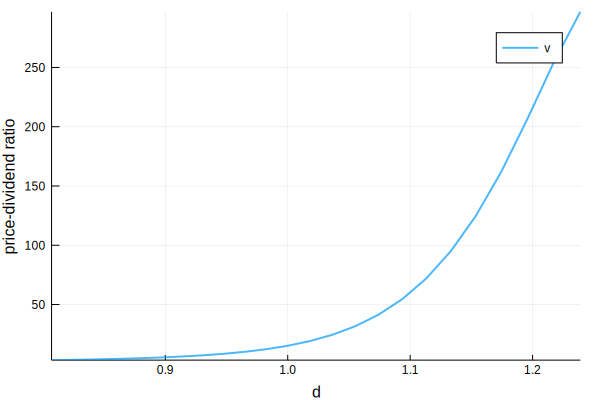

In [4]:
n = 25
mc = tauchen(n, 0.96, 0.02) #uses n nodes x_{t+1} = 0.96 x_t + 0.02 epsilon_t, where epsilon_t ~ N(0,1)
P = mc.p #Extract transition matrix
x = mc.state_values'  #Extract the states

#Details for the dividend process and utility
β = 0.9
g(x) = exp(x) #The g function given a state

K = P .* g.(x)' # equation 8
@assert maximum(abs, eigvals(K)) < 1/β #Otherwise unstable

one_column = ones(n, 1)
v = (I - β * K) \  (β * K * one_column) #equation 10

d = g.(x) #The dividends d_t = g(x_t)
plot(d', v, lw=2, ylabel="price-dividend ratio", xlabel="d", alpha=0.7, label="v")

## Asset Prices under Risk Aversion: Pricing a Lucas Tree

In [5]:
#Generator for the default values
ap_defaults = @with_kw(
    β = 0.96,
    γ = 2.0,
    σ = 2.0,
    mc = tauchen(25, 0.9, 0.02), # default markov chain is a discretized AR(1)
    g = exp #exponential
)

function tree_price(ap)
    #Extract from the tuple
    @unpack β, γ, mc, g = ap
    
    P = mc.p
    y = mc.state_values'
    n = length(y)

    J = P .* g.(y).^(1 - γ) #Above (14) in the section
    @assert maximum(abs, eigvals(J)) < 1/β #Otherwise unstable
    
    one_column = ones(n, 1)
    v = (I - β * J) \ (β * J * one_column) # equation (14)

    return v
end


tree_price (generic function with 1 method)

## Calculating the price

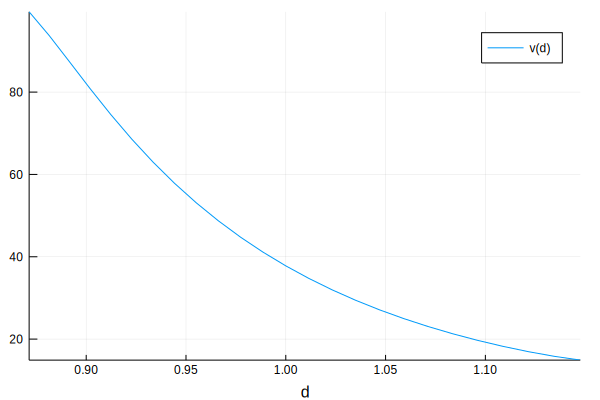

In [6]:
ap = ap_defaults()
v = tree_price(ap)
x = ap.mc.state_values
d = ap.g.(x) #Calls ap.g(x) for each x in the state_values
plot(d, v, label = "v(d)", xlabel="d")

## Calculating the price for various γ

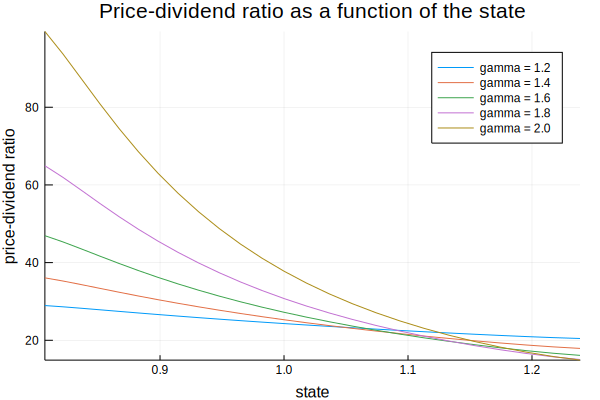

In [47]:
γs = [1.2, 1.4, 1.6, 1.8, 2.0]

#Will push the lines and labels onto these arrays
lines = []
labels = []

for γ in γs
    ap = ap_defaults(γ=γ)
    
    v = tree_price(ap)
    label="gamma = $γ"
    push!(labels, label)
    push!(lines, v)
end

#Get the ap
ap = ap_defaults(γ=γs[1]) #Get the parameters for the first γ
x = mc.state_values
d = ap.g.(x) #Calls ap.g(x) for each x in the state_values


#Note explanat6ion in notes for dropping price as a function of state:
#"This is because, with a positively correlated state process, higher states suggest higher future consumption growth
#In the stochastic discount factor (13), higher growth decreases the discount factor, lowering the weight placed on future returns"

plot(d, lines,
    labels=labels,
    title="Price-dividend ratio as a function of the state",
    ylabel="price-dividend ratio",
    xlabel="state")

## Risk-Free Consol
Pricing a risk-free consol with the stochastic discount factor form the CRRA preferences

In [31]:
function consol_price(ap, ζ)
    
    #Extract from the tuple
    @unpack β, γ, mc, g = ap
    
    #Stochastic Process for the SDF
    P = mc.p
    y = mc.state_values'
    n = length(y)

    #Stack up the stochastic discount factor
    M = P .* g.(y).^(- γ) #Below equation (15)
    @assert maximum(abs, eigvals(M)) < 1/β #Otherwise unstable
    
    one_column = ones(n, 1)
    return (I - β * M) \ (β * M * ζ * one_column) # equation (16)
end

consol_price (generic function with 2 methods)

## Pricing the Consol 
Use the underlying dynamics from the previous section for aggregate consumption

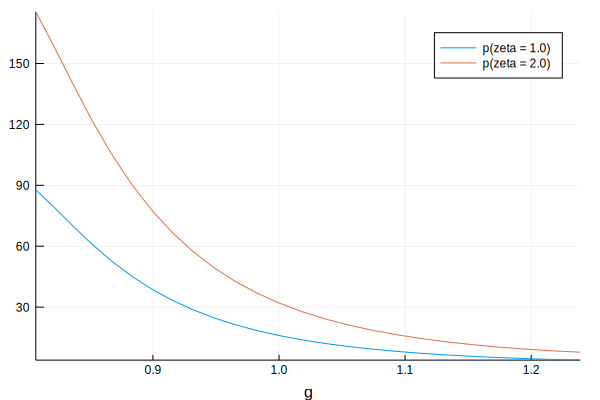

In [56]:
#Use the defaults from before
ap = ap_defaults(β=0.90, mc = tauchen(n, 0.90, 0.02))

x = mc.state_values
d = ap.g.(x) #Calls ap.g(x) for each x in the state_values

plot(ap.g.(x), [consol_price(ap, 1.0), consol_price(ap, 2.0)], xlabel="g", label=["p(zeta = 1.0)" "p(zeta = 2.0)"])

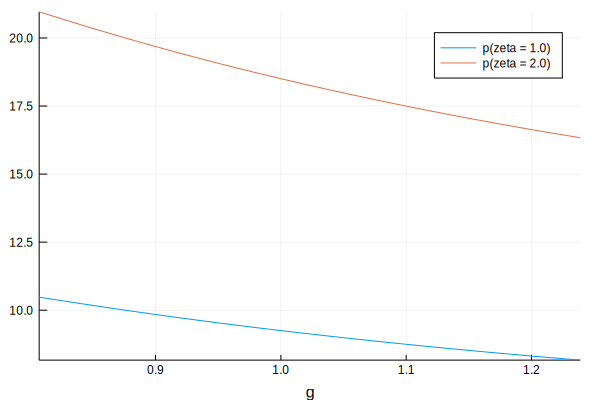

In [58]:
#Now with less persistence
ap = ap_defaults(β=0.90, mc = tauchen(n, 0.5, 0.02))

x = mc.state_values
d = ap.g.(x) #Calls ap.g(x) for each x in the state_values

plot(ap.g.(x), [consol_price(ap, 1.0), consol_price(ap, 2.0)], xlabel="g", label=["p(zeta = 1.0)" "p(zeta = 2.0)"])